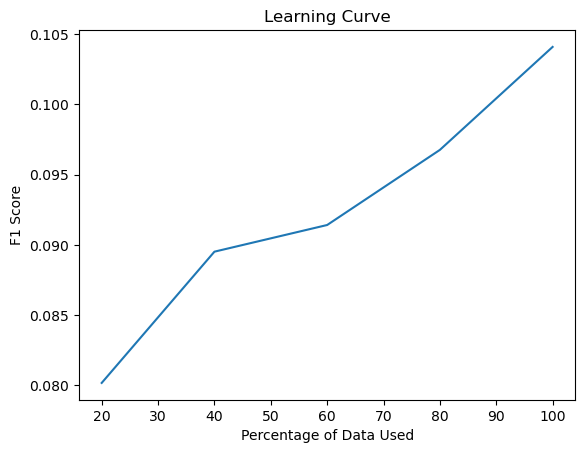

In [1]:
import torch
from datasets import load_dataset
from torch import nn, optim
from sklearn.metrics import f1_score
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import random

PAD = "PAD"
UNK = "UNK"
DIM_EMBEDDING = 100
LSTM_HIDDEN = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.01
EPOCHS = 10

def read_conll_file(dataset):
    data = []
    for example in dataset:
        words = example['tokens']
        tags = example['ner_tags']
        data.append((words, tags))
    return data

class NERDataset(Dataset):
    def __init__(self, data, word_vocab, tag_vocab):
        self.data = data
        self.word_vocab = word_vocab
        self.tag_vocab = tag_vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        words, tags = self.data[idx]
        word_indices = [self.word_vocab.get(word, self.word_vocab[UNK]) for word in words]
        tag_indices = [self.tag_vocab[tag] for tag in tags]
        return torch.tensor(word_indices, dtype=torch.long), torch.tensor(tag_indices, dtype=torch.long)

def build_vocab(data):
    word_vocab = defaultdict(lambda: len(word_vocab))
    tag_vocab = defaultdict(lambda: len(tag_vocab))
    word_vocab[PAD]
    word_vocab[UNK]
    for sentence, tags in data:
        for word in sentence:
            word_vocab[word]
        for tag in tags:
            tag_vocab[tag]
    return dict(word_vocab), dict(tag_vocab)

def collate_fn(batch):
    word_seqs, tag_seqs = zip(*batch)
    word_seqs_padded = pad_sequence(word_seqs, batch_first=True, padding_value=0)
    tag_seqs_padded = pad_sequence(tag_seqs, batch_first=True, padding_value=0)
    return word_seqs_padded, tag_seqs_padded

all_data = load_dataset('wnut_17')
train_data = read_conll_file(all_data['train'])
dev_data = read_conll_file(all_data['test'])

word_vocab, tag_vocab = build_vocab(train_data)
train_dataset = NERDataset(train_data, word_vocab, tag_vocab)
dev_dataset = NERDataset(dev_data, word_vocab, tag_vocab)

def create_subsets(dataset, fractions):
    subsets = []
    total_size = len(dataset)
    indices = list(range(total_size))
    random.shuffle(indices)

    for fraction in fractions:
        subset_size = int(fraction * total_size)
        subset_indices = indices[:subset_size]
        subsets.append(Subset(dataset, subset_indices))

    return subsets

fractions = [0.2, 0.4, 0.6, 0.8, 1.0]
train_subsets = create_subsets(train_dataset, fractions)

class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=DIM_EMBEDDING, hidden_dim=LSTM_HIDDEN):
        super(SimpleLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.hidden2tag(lstm_out)
        return tag_space

def train_and_evaluate_on_subset(subset):
    train_loader = DataLoader(subset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)

    model = SimpleLSTM(len(word_vocab), len(tag_vocab))
    loss_function = nn.CrossEntropyLoss(ignore_index=-100)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(EPOCHS):
        model.train()
        for words, tags in train_loader:
            model.zero_grad()
            tag_scores = model(words)
            loss = loss_function(tag_scores.view(-1, len(tag_vocab)), tags.view(-1))
            loss.backward()
            optimizer.step()

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for words, tags in dev_loader:
            tag_scores = model(words)
            preds = torch.argmax(tag_scores, dim=2)
            all_preds.extend(preds.view(-1).tolist())
            all_labels.extend(tags.view(-1).tolist())

    # Filter out padding tokens
    filtered_preds = [p for p, l in zip(all_preds, all_labels) if l != -100]
    filtered_labels = [l for l in all_labels if l != -100]

    f1 = f1_score(filtered_labels, filtered_preds, average='macro')
    return f1

f1_scores = []
for subset in train_subsets:
    f1 = train_and_evaluate_on_subset(subset)
    f1_scores.append(f1)


plt.plot([fraction * 100 for fraction in fractions], f1_scores)
plt.xlabel('Percentage of Data Used')
plt.ylabel('F1 Score')
plt.title('Learning Curve')
plt.show()


In [ ]:
import torch
from datasets import load_dataset
from torch import nn, optim
import torch.nn.functional as F
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import defaultdict, Counter
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import random
import numpy as np

#Constants
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"
PAD_TAG_STR = "_PAD_"
START_TAG = "<START>"
STOP_TAG = "<STOP>"

DIM_EMBEDDING = 100
LSTM_HIDDEN = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.01
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

#Focal Loss Implementation
class FocalLoss(nn.Module):
    """Focal Loss for addressing class imbalance."""
    def __init__(self, alpha=1.0, gamma=2.0, ignore_index=-100):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, ignore_index=self.ignore_index, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

#Enhanced CRF Implementation
class CRF(nn.Module):
    """Conditional Random Field layer with class weighting support."""
    
    def __init__(self, num_tags, start_tag_idx, end_tag_idx, pad_tag_idx, class_weights=None):
        super(CRF, self).__init__()
        self.num_tags = num_tags
        self.start_tag_idx = start_tag_idx
        self.end_tag_idx = end_tag_idx
        self.pad_tag_idx = pad_tag_idx
        
        if class_weights is not None:
            self.register_buffer('class_weights', torch.FloatTensor(class_weights))
        else:
            self.class_weights = None
        
        self.transitions = nn.Parameter(torch.randn(num_tags, num_tags))
        
        self.transitions.data[start_tag_idx, :] = -10000
        self.transitions.data[:, end_tag_idx] = -10000
        
    def _compute_partition_function(self, emissions, mask):
        """Compute the partition function using forward algorithm."""
        batch_size, seq_length, num_tags = emissions.shape
        
        if self.class_weights is not None:
            emissions = emissions * self.class_weights.unsqueeze(0).unsqueeze(0)
        
        alpha = torch.full((batch_size, num_tags), -10000.0, device=emissions.device)
        alpha[:, self.start_tag_idx] = 0.0
        
        for i in range(seq_length):
            alpha_broadcast = alpha.unsqueeze(2).expand(batch_size, num_tags, num_tags)
            transition_scores = alpha_broadcast + self.transitions.unsqueeze(0)
            emission_scores = emissions[:, i, :]
            new_alpha = torch.logsumexp(transition_scores, dim=1) + emission_scores
            alpha = torch.where(mask[:, i].unsqueeze(1), new_alpha, alpha)
        
        final_alpha = alpha + self.transitions[self.end_tag_idx].unsqueeze(0)
        return torch.logsumexp(final_alpha, dim=1)
    
    def _compute_score(self, emissions, tags, mask):
        """Compute the score of the given tag sequence."""
        batch_size, seq_length = tags.shape
        
        if self.class_weights is not None:
            emissions = emissions * self.class_weights.unsqueeze(0).unsqueeze(0)
        
        tags_with_start_end = torch.full((batch_size, seq_length + 2), self.pad_tag_idx, 
                                         dtype=torch.long, device=tags.device)
        tags_with_start_end[:, 0] = self.start_tag_idx
        tags_with_start_end[:, 1:-1] = tags
        tags_with_start_end[:, -1] = self.end_tag_idx
        
        mask_with_start_end = torch.ones((batch_size, seq_length + 2), dtype=torch.bool, device=mask.device)
        mask_with_start_end[:, 1:-1] = mask
        
        score = torch.zeros(batch_size, device=emissions.device)
        
        for i in range(seq_length):
            valid_mask = mask[:, i]
            if valid_mask.any():
                score[valid_mask] += emissions[valid_mask, i, tags[valid_mask, i]]
        
        for i in range(seq_length + 1):
            valid_mask = mask_with_start_end[:, i+1]
            if valid_mask.any():
                score[valid_mask] += self.transitions[
                    tags_with_start_end[valid_mask, i+1], 
                    tags_with_start_end[valid_mask, i]
                ]
        
        return score
    
    def forward(self, emissions, tags, mask):
        """Compute the negative log likelihood."""
        partition = self._compute_partition_function(emissions, mask)
        score = self._compute_score(emissions, tags, mask)
        return (partition - score).mean()
    
    def decode(self, emissions, mask):
        """Find the most likely tag sequence using Viterbi algorithm."""
        batch_size, seq_length, num_tags = emissions.shape
        
        if self.class_weights is not None:
            emissions = emissions * self.class_weights.unsqueeze(0).unsqueeze(0)
        
        viterbi_score = torch.full((batch_size, num_tags), -10000.0, device=emissions.device)
        viterbi_score[:, self.start_tag_idx] = 0.0
        viterbi_path = []
        
        for i in range(seq_length):
            broadcast_score = viterbi_score.unsqueeze(2).expand(batch_size, num_tags, num_tags)
            transition_scores = broadcast_score + self.transitions.unsqueeze(0)
            best_score, best_path = torch.max(transition_scores, dim=1)
            new_score = best_score + emissions[:, i, :]
            viterbi_score = torch.where(mask[:, i].unsqueeze(1), new_score, viterbi_score)
            viterbi_path.append(best_path)
        
        final_score = viterbi_score + self.transitions[self.end_tag_idx].unsqueeze(0)
        best_final_score, last_tag = torch.max(final_score, dim=1)
        
        best_path = []
        for i in range(batch_size):
            path = [last_tag[i].item()]
            
            for j in range(seq_length - 1, -1, -1):
                if mask[i, j]:
                    path.append(viterbi_path[j][i, path[-1]].item())
            path.reverse()
            best_path.append(path[1:])
        
        return best_path

#Data Processing Functions
def process_dataset_examples(dataset_split, tag_names_list):
    """Processes examples from a Hugging Face dataset split."""
    data = []
    for example in dataset_split:
        words = example['tokens']
        str_tags = [tag_names_list[t] for t in example['ner_tags']]
        data.append((words, str_tags))
    return data

class NERDataset(Dataset):
    def __init__(self, data, word_vocab, tag_vocab):
        self.data = data
        self.word_vocab = word_vocab
        self.tag_vocab = tag_vocab
        self.unk_word_idx = self.word_vocab[UNK_TOKEN]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        words, tags_str = self.data[idx]
        word_indices = [self.word_vocab.get(word, self.unk_word_idx) for word in words]
        tag_indices = [self.tag_vocab[tag] for tag in tags_str]
        return torch.tensor(word_indices, dtype=torch.long), torch.tensor(tag_indices, dtype=torch.long)

def build_vocab(data, tag_names_from_hf):
    word_vocab = defaultdict(lambda: len(word_vocab))
    tag_vocab_str_to_int = defaultdict(lambda: len(tag_vocab_str_to_int))

    word_vocab[PAD_TOKEN]
    word_vocab[UNK_TOKEN]

    tag_vocab_str_to_int[PAD_TAG_STR]
    tag_vocab_str_to_int[START_TAG]
    tag_vocab_str_to_int[STOP_TAG]

    for sentence, tags_str_list in data:
        for word in sentence:
            word_vocab[word]
        for tag_str in tags_str_list:
            tag_vocab_str_to_int[tag_str]

    for tag_name in tag_names_from_hf:
        tag_vocab_str_to_int[tag_name]

    return dict(word_vocab), dict(tag_vocab_str_to_int)

def collate_fn(batch, word_pad_idx, tag_pad_idx):
    word_seqs, tag_seqs = zip(*batch)
    word_seqs_padded = pad_sequence(word_seqs, batch_first=True, padding_value=word_pad_idx)
    tag_seqs_padded = pad_sequence(tag_seqs, batch_first=True, padding_value=tag_pad_idx)
    return word_seqs_padded, tag_seqs_padded

def compute_class_weights_from_data(train_data, tag_vocab):
    """Compute class weights to handle imbalance."""
    all_tags = []
    for _, tags in train_data:
        all_tags.extend([tag_vocab[tag] for tag in tags])
    
    observed_tag_indices = list(set(all_tags))
    
    if len(all_tags) == 0: 
        print("No tags in training data to compute weights. Returning uniform weights.")
        return np.ones(len(tag_vocab))

    class_weights_raw = compute_class_weight('balanced', classes=np.array(sorted(observed_tag_indices)), y=all_tags)
    
    full_class_weights = np.ones(len(tag_vocab), dtype=np.float32)
    for i, tag_idx in enumerate(sorted(observed_tag_indices)):
        full_class_weights[tag_idx] = class_weights_raw[i]

    if tag_vocab[PAD_TAG_STR] < len(full_class_weights):
        full_class_weights[tag_vocab[PAD_TAG_STR]] = 0.0
    if tag_vocab[START_TAG] < len(full_class_weights):
        full_class_weights[tag_vocab[START_TAG]] = 0.0
    if tag_vocab[STOP_TAG] < len(full_class_weights):
        full_class_weights[tag_vocab[STOP_TAG]] = 0.0

    print("Class distribution:")
    tag_counter = Counter(all_tags)
    for tag_name, tag_idx in sorted(tag_vocab.items(), key=lambda x: x[1]):
        count = tag_counter.get(tag_idx, 0)
        weight = full_class_weights[tag_idx]
        print(f"  {tag_name}: {count} samples (weight: {weight:.3f})")
    
    return full_class_weights

#Model Definition
class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim, word_pad_idx, 
                 start_tag_idx, end_tag_idx, pad_tag_idx, class_weights=None):
        super(BiLSTM_CRF, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=word_pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size)
        self.dropout = nn.Dropout(0.1)
        self.crf = CRF(tagset_size, start_tag_idx, end_tag_idx, pad_tag_idx, class_weights)

    def forward(self, sentence_batch, tags_batch=None, mask=None):
        embeds = self.embedding(sentence_batch)
        embeds = self.dropout(embeds)
        lstm_out, _ = self.lstm(embeds)
        lstm_out = self.dropout(lstm_out)
        emissions = self.hidden2tag(lstm_out)
        
        if tags_batch is not None:
            return self.crf(emissions, tags_batch, mask)
        else:
            return self.crf.decode(emissions, mask)

#Enhanced Evaluation
def create_mask(padded_sequences, pad_idx):
    """Create mask for padded sequences."""
    return (padded_sequences != pad_idx)

def get_entity_labels(tag_vocab, exclude_tags={'_PAD_', '<START>', '<STOP>', 'O'}):
    """Get indices of entity tags (excluding O, PAD, START, STOP)."""
    entity_indices = []
    entity_names = []
    for tag_name, tag_idx in tag_vocab.items():
        if tag_name not in exclude_tags:
            entity_indices.append(tag_idx)
            entity_names.append(tag_name)
    return entity_indices, entity_names

def evaluate_model_enhanced(model, data_loader, tag_pad_idx, device, tag_vocab, verbose=False):
    """Enhanced evaluation with detailed metrics."""
    model.eval()
    all_preds_flat = []
    all_labels_flat = []

    with torch.no_grad():
        for sentences, tags in data_loader:
            sentences, tags = sentences.to(device), tags.to(device)
            mask = create_mask(tags, tag_pad_idx)
            
            pred_sequences = model(sentences, mask=mask)
            
            for i, (pred_seq, true_seq, seq_mask) in enumerate(zip(pred_sequences, tags, mask)):
                valid_length = seq_mask.sum().item()

                pred_seq_valid = pred_seq[:valid_length]
                true_seq_valid = true_seq[:valid_length].cpu().numpy()
                
                all_preds_flat.extend(pred_seq_valid)
                all_labels_flat.extend(true_seq_valid)
    
    if not all_labels_flat:
        print("No valid labels found for evaluation.")
        return 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    
    # Overall metrics
    accuracy = accuracy_score(all_labels_flat, all_preds_flat)
    precision_macro = precision_score(all_labels_flat, all_preds_flat, average='macro', zero_division=0)
    recall_macro = recall_score(all_labels_flat, all_preds_flat, average='macro', zero_division=0)
    f1_macro = f1_score(all_labels_flat, all_preds_flat, average='macro', zero_division=0)
    
    # Entity-only metrics (excluding O tag)
    entity_indices, entity_names = get_entity_labels(tag_vocab)
    
    filtered_preds_for_entity = []
    filtered_labels_for_entity = []
    for p, l in zip(all_preds_flat, all_labels_flat):
        if l in entity_indices: 
            filtered_labels_for_entity.append(l)
            filtered_preds_for_entity.append(p)
    
    f1_entity = 0.0
    precision_entity = 0.0
    
    if filtered_labels_for_entity: 
        f1_entity = f1_score(filtered_labels_for_entity, filtered_preds_for_entity, 
                             labels=entity_indices, average='macro', zero_division=0)
        precision_entity = precision_score(filtered_labels_for_entity, filtered_preds_for_entity, 
                                          labels=entity_indices, average='macro', zero_division=0)
    
    if verbose:
        print("\n=== DETAILED EVALUATION ===")
        pred_counter = Counter(all_preds_flat)
        true_counter = Counter(all_labels_flat)
        
        print("Prediction distribution:")
        for tag_name, tag_idx in sorted(tag_vocab.items(), key=lambda x: x[1]):
            pred_count = pred_counter.get(tag_idx, 0)
            true_count = true_counter.get(tag_idx, 0)
            print(f"  {tag_name:15} - Predicted: {pred_count:6}, True: {true_count:6}")
        
        print(f"\nOverall Metrics:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Macro F1: {f1_macro:.4f}")
        print(f"  Macro Precision: {precision_macro:.4f}")
        print(f"  Macro Recall: {recall_macro:.4f}")
        
        print(f"\nEntity-only Metrics (excluding O):")
        print(f"  Entity F1: {f1_entity:.4f}")
        print(f"  Entity Precision: {precision_entity:.4f}")
        
        if entity_indices and filtered_labels_for_entity:
            idx_to_tag_name = {v: k for k, v in tag_vocab.items()}
            target_names_for_report = [idx_to_tag_name[idx] for idx in entity_indices]
            print(f"\nClassification Report (Entities Only):")
            print(classification_report(filtered_labels_for_entity, filtered_preds_for_entity, 
                                        labels=entity_indices, target_names=target_names_for_report, 
                                        zero_division=0))
    
    return accuracy, precision_macro, recall_macro, f1_macro, f1_entity, precision_entity

def train_model_enhanced(model, train_loader, dev_loader, optimizer, epochs, tag_pad_idx, device, tag_vocab, subset_fraction):
    """Enhanced training with better monitoring."""
    best_entity_f1 = -1
    metrics_history = {'accuracy': [], 'f1_macro': [], 'f1_entity': []}

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        num_batches = 0
        
        for sentences, tags in train_loader:
            sentences, tags = sentences.to(device), tags.to(device)
            mask = create_mask(tags, tag_pad_idx)
            
            model.zero_grad()
            loss = model(sentences, tags, mask)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        avg_train_loss = epoch_loss / num_batches if num_batches > 0 else 0
        
        #Evaluate
        accuracy, precision_macro, recall_macro, f1_macro, f1_entity, precision_entity = evaluate_model_enhanced(
            model, dev_loader, tag_pad_idx, device, tag_vocab, verbose=(epoch == epochs-1)
        )
        
        print(f"Subset: {subset_fraction*100:.0f}%, Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Dev Accuracy: {accuracy:.4f}, Macro F1: {f1_macro:.4f}, Entity F1: {f1_entity:.4f}")

        metrics_history['accuracy'].append(accuracy)
        metrics_history['f1_macro'].append(f1_macro)
        metrics_history['f1_entity'].append(f1_entity)
        
        if f1_entity > best_entity_f1:
            best_entity_f1 = f1_entity

    return accuracy, precision_macro, recall_macro, f1_macro, f1_entity, model

#Robustness Testing Functions
def introduce_typos(tokens, typo_rate=0.1):
    """Introduces typos into a list of tokens."""
    noisy_tokens = []
    for token in tokens:
        if random.random() < typo_rate and len(token) > 1:
            idx_to_change = random.randint(0, len(token) - 1)
            char_code = ord(token[idx_to_change])
            try:
                if 'a' <= token[idx_to_change] <= 'z':
                    noisy_char_code = char_code + random.choice([-1, 1])
                    if not ('a' <= chr(noisy_char_code) <= 'z'):
                        noisy_char_code = random.randint(ord('a'), ord('z'))
                elif 'A' <= token[idx_to_change] <= 'Z':
                    noisy_char_code = char_code + random.choice([-1, 1])
                    if not ('A' <= chr(noisy_char_code) <= 'Z'):
                        noisy_char_code = random.randint(ord('A'), ord('Z'))
                elif '0' <= token[idx_to_change] <= '9':
                    noisy_char_code = char_code + random.choice([-1, 1])
                    if not ('0' <= chr(noisy_char_code) <= '9'):
                        noisy_char_code = random.randint(ord('0'), ord('9'))
                else: 
                    noisy_char_code = random.randint(ord('a'), ord('z'))

                noisy_char = chr(noisy_char_code)
                noisy_token = list(token)
                noisy_token[idx_to_change] = noisy_char
                noisy_tokens.append("".join(noisy_token))
            except ValueError:
                noisy_tokens.append(token)
        else:
            noisy_tokens.append(token)
    return noisy_tokens

def introduce_unks(tokens, word_vocab, unk_rate=0.1):
    """Replaces some tokens with the UNK_TOKEN string."""
    noisy_tokens = []
    for token in tokens:
        if random.random() < unk_rate and token in word_vocab and word_vocab[token] != word_vocab[UNK_TOKEN]:
            noisy_tokens.append(UNK_TOKEN)
        else:
            noisy_tokens.append(token)
    return noisy_tokens

#Main Execution
if __name__ == "__main__":
    # Load WNUT17
    wnut_dataset = load_dataset('wnut_17')
    tag_names_list = wnut_dataset['train'].features['ner_tags'].feature.names

    train_data_processed = process_dataset_examples(wnut_dataset['train'], tag_names_list)
    dev_data_processed = process_dataset_examples(wnut_dataset['validation'], tag_names_list)
    test_data_processed = process_dataset_examples(wnut_dataset['test'], tag_names_list)

    all_data_for_vocab = train_data_processed + dev_data_processed + test_data_processed
    word_vocab, tag_vocab = build_vocab(all_data_for_vocab, tag_names_list)
    
    word_pad_idx = word_vocab[PAD_TOKEN]
    tag_pad_idx = tag_vocab[PAD_TAG_STR]
    start_tag_idx = tag_vocab[START_TAG]
    end_tag_idx = tag_vocab[STOP_TAG]
    num_tags = len(tag_vocab)

    print(f"Word vocab size: {len(word_vocab)}")
    print(f"Tag vocab size: {num_tags}")
    print(f"Tag vocabulary: {list(tag_vocab.keys())}")

    class_weights = compute_class_weights_from_data(train_data_processed, tag_vocab)
    
    full_train_dataset = NERDataset(train_data_processed, word_vocab, tag_vocab)
    dev_dataset_torch = NERDataset(dev_data_processed, word_vocab, tag_vocab)
    
    dev_loader = DataLoader(dev_dataset_torch, batch_size=BATCH_SIZE, 
                            collate_fn=lambda b: collate_fn(b, word_pad_idx, tag_pad_idx))

    print("\n=== Starting Enhanced BiLSTM-CRF Experiments ===")
    fractions = [0.2, 0.4, 0.6, 0.8, 1.0]
    data_efficiency_results = defaultdict(list)
    
    trained_model_full_data = None

    for fraction in fractions:
        subset_size = int(fraction * len(full_train_dataset))
        indices = list(range(len(full_train_dataset)))
        random.shuffle(indices)
        train_subset_torch = Subset(full_train_dataset, indices[:subset_size])
        
        train_loader_subset = DataLoader(train_subset_torch, batch_size=BATCH_SIZE, shuffle=True,
                                         collate_fn=lambda b: collate_fn(b, word_pad_idx, tag_pad_idx))

        model = BiLSTM_CRF(len(word_vocab), num_tags, DIM_EMBEDDING, LSTM_HIDDEN, word_pad_idx,
                           start_tag_idx, end_tag_idx, tag_pad_idx, class_weights).to(DEVICE)
        
        optimizer = optim.Adam([
            {'params': model.embedding.parameters(), 'lr': LEARNING_RATE * 0.1},
            {'params': model.lstm.parameters(), 'lr': LEARNING_RATE},
            {'params': model.hidden2tag.parameters(), 'lr': LEARNING_RATE},
            {'params': model.crf.parameters(), 'lr': LEARNING_RATE}
        ])

        print(f"\nTraining Enhanced BiLSTM-CRF on {fraction*100:.0f}% of data ({len(train_subset_torch)} samples)...")
        accuracy, precision, recall, f1_macro, f1_entity, trained_model_current = train_model_enhanced(
            model, train_loader_subset, dev_loader, optimizer, EPOCHS, tag_pad_idx, DEVICE, tag_vocab, fraction
        )
        
        data_efficiency_results['fraction'].append(fraction * 100)
        data_efficiency_results['accuracy'].append(accuracy)
        data_efficiency_results['precision'].append(precision)
        data_efficiency_results['recall'].append(recall)
        data_efficiency_results['f1_macro'].append(f1_macro)
        data_efficiency_results['f1_entity'].append(f1_entity)

        if fraction == 1.0:
            trained_model_full_data = trained_model_current

    # Plotting Results
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(data_efficiency_results['fraction'], data_efficiency_results['accuracy'], 'o-', label='Accuracy')
    plt.plot(data_efficiency_results['fraction'], data_efficiency_results['f1_macro'], 's-', label='Macro F1')
    plt.plot(data_efficiency_results['fraction'], data_efficiency_results['f1_entity'], '^-', label='Entity F1')
    plt.xlabel('Training Data (%)')
    plt.ylabel('Score')
    plt.title('Enhanced BiLSTM-CRF: Data Efficiency')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(data_efficiency_results['fraction'], data_efficiency_results['precision'], 'o-', label='Precision')
    plt.plot(data_efficiency_results['fraction'], data_efficiency_results['recall'], 's-', label='Recall')
    plt.xlabel('Training Data (%)')
    plt.ylabel('Score')
    plt.title('Precision vs Recall')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("enhanced_bilstm_crf_results.png", dpi=300, bbox_inches='tight')
    print("Saved enhanced results plot to enhanced_bilstm_crf_results.png")

    # Robustness Testing
    if trained_model_full_data:
        print("\n=== Robustness Testing ===")
        
        # Clean evaluation
        print("Clean Dev Set:")
        evaluate_model_enhanced(trained_model_full_data, dev_loader, tag_pad_idx, DEVICE, tag_vocab, verbose=True)
        
        # Typos evaluation
        print(f"\n--- With Typos (10%) ---")
        typo_rate = 0.1
        dev_data_typos = [(introduce_typos(words, typo_rate), tags) for words, tags in dev_data_processed]
        dev_dataset_typos = NERDataset(dev_data_typos, word_vocab, tag_vocab)
        dev_loader_typos = DataLoader(dev_dataset_typos, batch_size=BATCH_SIZE,
                                      collate_fn=lambda b: collate_fn(b, word_pad_idx, tag_pad_idx))
        evaluate_model_enhanced(trained_model_full_data, dev_loader_typos, tag_pad_idx, DEVICE, tag_vocab, verbose=True)
        
        # UNK evaluation
        print(f"\n--- With UNKs (10%) ---")
        unk_rate = 0.1
        dev_data_unks = [(introduce_unks(words, word_vocab, unk_rate), tags) for words, tags in dev_data_processed]
        dev_dataset_unks = NERDataset(dev_data_unks, word_vocab, tag_vocab)
        dev_loader_unks = DataLoader(dev_dataset_unks, batch_size=BATCH_SIZE,
                                     collate_fn=lambda b: collate_fn(b, word_pad_idx, tag_pad_idx))
        evaluate_model_enhanced(trained_model_full_data, dev_loader_unks, tag_pad_idx, DEVICE, tag_vocab, verbose=True)

    print("\n=== Enhanced BiLSTM-CRF Experiments Complete ===")
    print("Key improvements implemented:")
    print("- Class weighting to handle imbalance")
    print("- Separate entity-focused F1 metrics")
    print("- Enhanced evaluation with detailed breakdowns")
    print("- Gradient clipping and dropout for better training")
    print("- Different learning rates for different components")

Using device: cpu
Word vocab size: 20775
Tag vocab size: 16
Tag vocabulary: ['_PAD_', '<START>', '<STOP>', 'O', 'B-location', 'I-location', 'B-group', 'B-corporation', 'B-person', 'B-creative-work', 'B-product', 'I-person', 'I-creative-work', 'I-corporation', 'I-group', 'I-product']
Class distribution:
  _PAD_: 0 samples (weight: 0.000)
  <START>: 0 samples (weight: 0.000)
  <STOP>: 0 samples (weight: 0.000)
  O: 59570 samples (weight: 0.081)
  B-location: 548 samples (weight: 8.805)
  I-location: 245 samples (weight: 19.695)
  B-group: 264 samples (weight: 18.278)
  B-corporation: 221 samples (weight: 21.834)
  B-person: 660 samples (weight: 7.311)
  B-creative-work: 140 samples (weight: 34.467)
  B-product: 142 samples (weight: 33.982)
  I-person: 335 samples (weight: 14.404)
  I-creative-work: 206 samples (weight: 23.424)
  I-corporation: 46 samples (weight: 104.900)
  I-group: 150 samples (weight: 32.169)
  I-product: 203 samples (weight: 23.770)

=== Starting Enhanced BiLSTM-CRF E